In [1]:
# !pip install -r requirements.txt

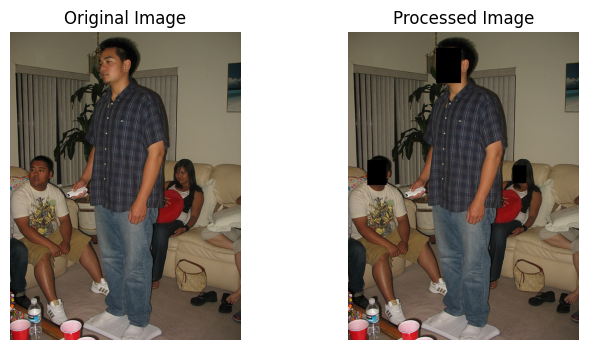

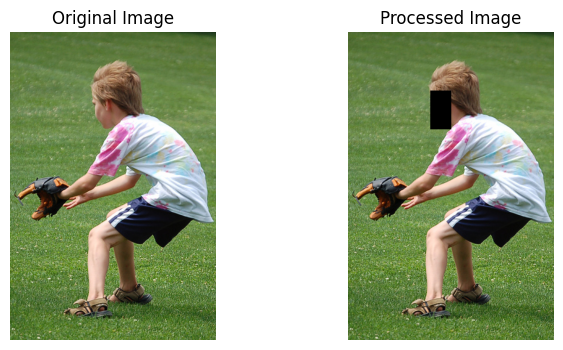

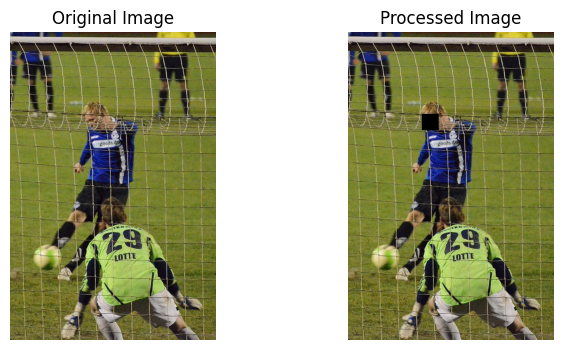

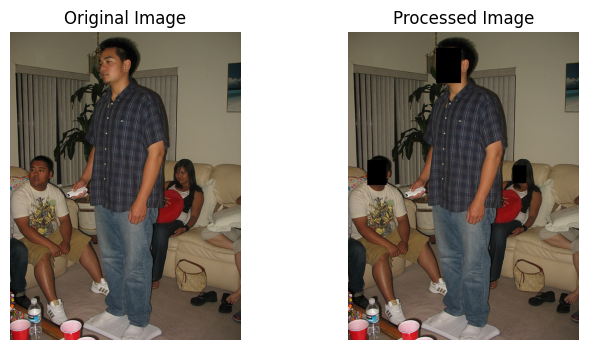

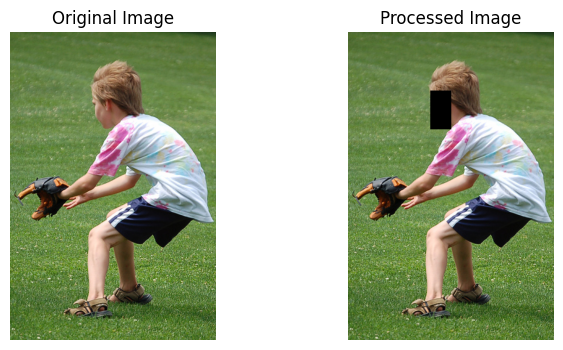

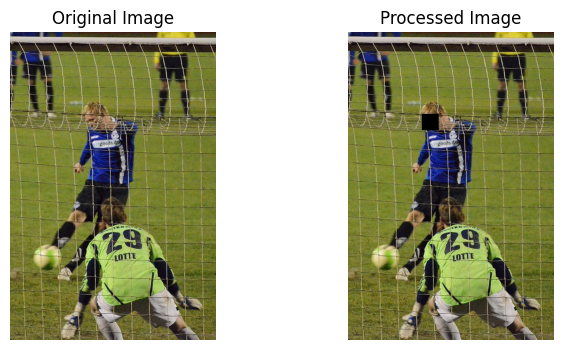

In [2]:
import os
import cv2
from retinaface import RetinaFace
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets as widgets

# Constants
YOLO_CLASS_INDEX = 2 # I assume that 0 is Person, 1 is Helmet so Head index is 2
IMG_EXTENSIONS = ['.png', '.jpg', '.jpeg']
DEFAULT_BLUR_STRENGTH = 25
PERSON_MODEL_PATH = './1-models/Person_Detector.pt'
HEAD_MODEL_PATH = './1-models/Head_detector_fromPersonBox_yolov5.pt'

# function to de_identify rectangle in image
def de_identify(image, rectangle, blur=False, blur_strength=DEFAULT_BLUR_STRENGTH):
    x1, y1, x2, y2 = rectangle
    if blur:
        roi = image[y1:y2, x1:x2]
        blurred_roi = cv2.GaussianBlur(roi, (blur_strength, blur_strength), 0)
        image[y1:y2, x1:x2] = blurred_roi
    else:
        image[y1:y2, x1:x2] = 0  # Set the rectangle region to black (zeros)

    return image

# Helper function to check if a file is an image file
def is_image_file(filename):
    return any(filename.lower().endswith(ext) for ext in IMG_EXTENSIONS)

# Main function to process the dataset
def process_dataset(input_path, output_path, yolo_class_index, visualize=True, blur=False):
    os.makedirs(output_path, exist_ok=True)
    retina_failed = []

    for root, _, files in os.walk(input_path):
        for filename in files:
            if is_image_file(filename):
                image_path = os.path.join(root, filename)
                resp = RetinaFace.detect_faces(image_path)

                if isinstance(resp, dict):
                    rel_image_path = os.path.relpath(image_path, input_path)
                    txt_output_path = os.path.join(output_path, os.path.splitext(rel_image_path)[0] + '.txt')
                    os.makedirs(os.path.dirname(txt_output_path), exist_ok=True)
                    
                    image = cv2.imread(image_path)
                    img_height, img_width, channels = image.shape

                    with open(txt_output_path, 'w') as f:
                        for key in resp:
                            facial_area = resp[key]['facial_area']
                            x_center = (facial_area[0] + facial_area[2]) / (2 * img_width)
                            y_center = (facial_area[1] + facial_area[3]) / (2 * img_height)
                            width = (facial_area[2] - facial_area[0])/img_width
                            height = (facial_area[3] - facial_area[1])/img_height
                            f.write(f"{yolo_class_index} {x_center} {y_center} {width} {height}\n")
                    
                    if visualize:
                        output_image_path = os.path.join(output_path, rel_image_path)
                        os.makedirs(os.path.dirname(output_image_path), exist_ok=True)
                        
                        for key in resp:
                            facial_area = resp[key]['facial_area']
                            image = de_identify(image, facial_area, blur=blur)
                        cv2.imwrite(output_image_path, image)
                        
                        # Uncomment Line 64 - 73, to Show the original and processed images while waiting!
                        plt.figure(figsize=(8, 4))
                        plt.subplot(1, 2, 1)
                        plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
                        plt.title('Original Image')
                        plt.axis('off')
                        plt.subplot(1, 2, 2)
                        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                        plt.title('Processed Image')
                        plt.axis('off')
                        # plt.show()
                        display(plt.gcf())

                else:
                    retina_failed.append(image_path)

    return(retina_failed)

################################################################################################################################
# Your inputs here:
# Define input and output paths

INPUT_PATH = './2-dataset/test'         # point to the main folder (subfolders will be processed as well)

OUTPUT_PATH = './4-output/blurred_test' # txt files and blurred images will be here, in the same format as original dataset.
                                        # output folder will be created in code automatically

Visualize = True    # if False, blured pictures wont be saved
                    # however, the yolo.txt files will be alwayes saved

Blur = False        # False for Black boxes over the faces (best for seeing model performance)
                    # set `Blur = True` if you need blur only

################################################################################################################################

# Process the dataset
retina_failed = process_dataset(INPUT_PATH, OUTPUT_PATH, YOLO_CLASS_INDEX, Visualize, Blur)


***************


Running second method for 17 Images failed in Retina


***************


Using cache found in C:\Users\noor/.cache\torch\hub\ultralytics_yolov5_master
WARNING  'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING  'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

YOLOv5  2023-7-21 Python-3.8.17 torch-2.0.1+cpu CPU

Fusing layers... 
Model summary: 396 layers, 35462484 parameters, 0 gradients
Adding AutoShape... 
Using cache found in C:\Users\noor/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-7-21 Python-3.8.17 torch-2.0.1+cpu CPU

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients
Adding AutoShape... 


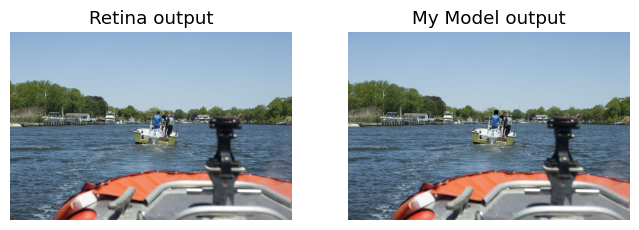

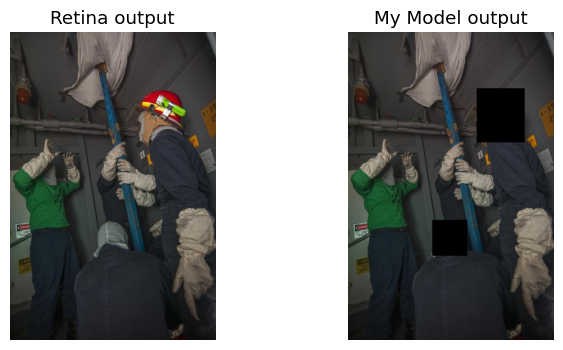

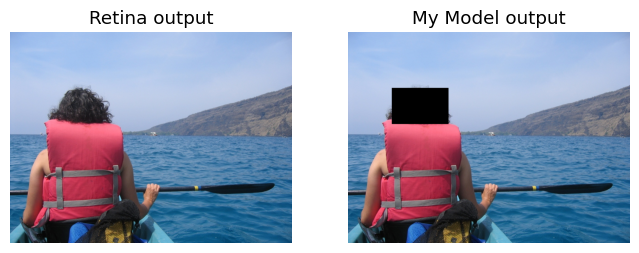

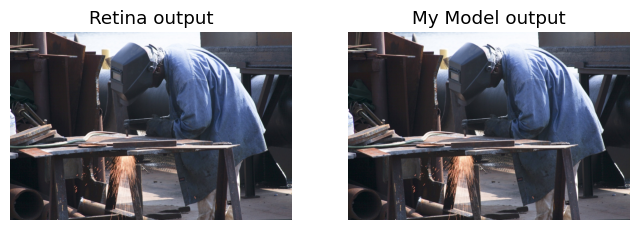

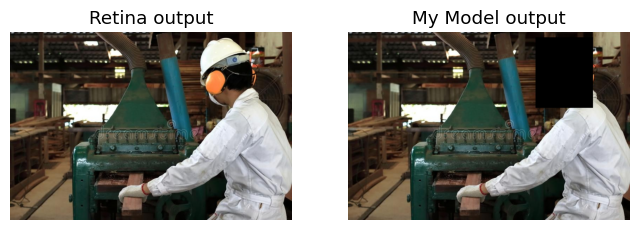

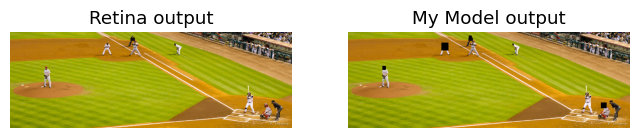

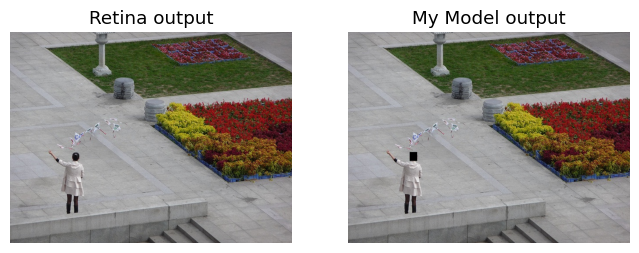

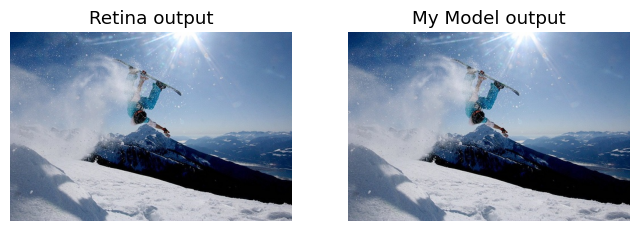

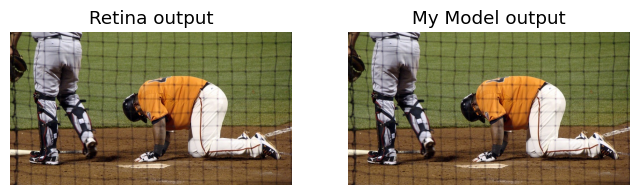

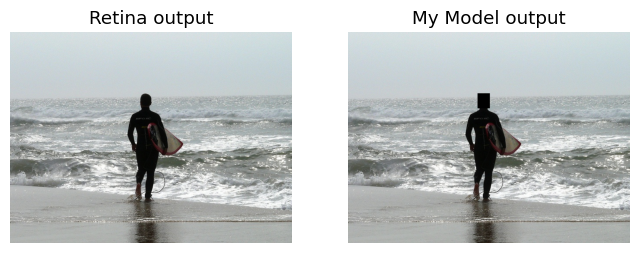

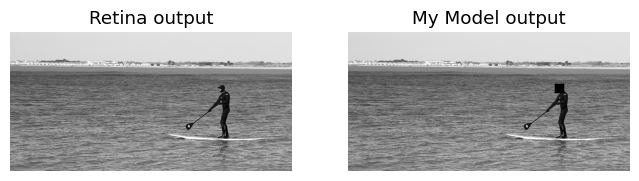

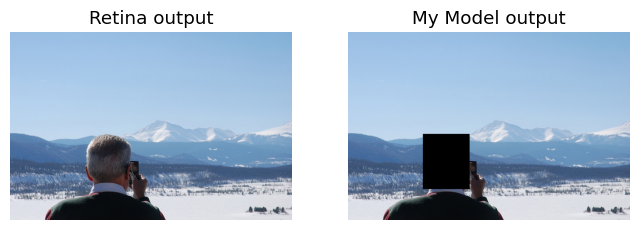

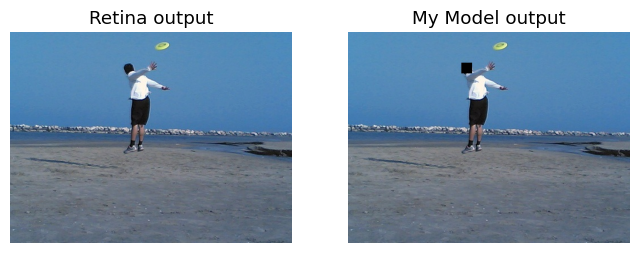

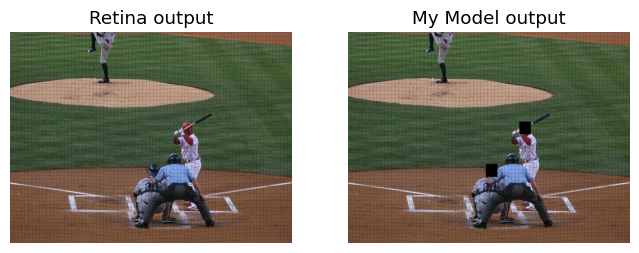

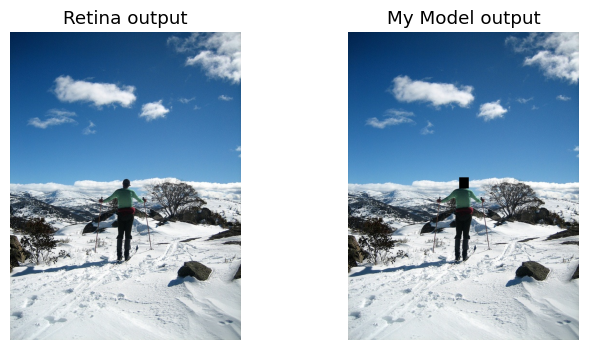

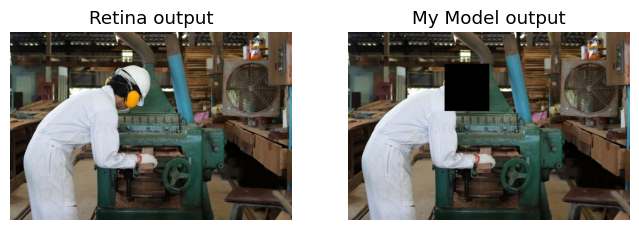

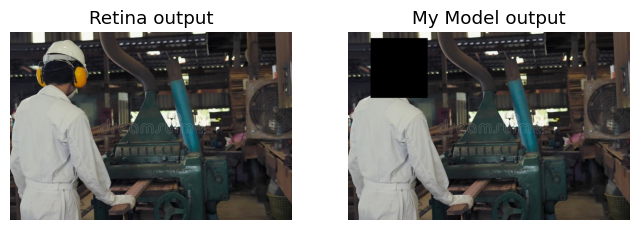

***************
yolo.txt files and blurred images using 2nd method are saved in ./4-output/blurred_test_NewMethod
***************


In [3]:
print(f"***************\n\n\nRunning second method for {len(retina_failed)} Images failed in Retina\n\n\n***************")


import torch
OUTPUT_PATH_NEW = OUTPUT_PATH +'_NewMethod'

# Model loading function
def load_model(model_path, model_name='custom'):
    return torch.hub.load('ultralytics/yolov5', model_name, path=model_path)

def process_imagelist_yolo(images, output_path, person_model, head_model, yolo_class_index, visualize=True, blur=False):

    os.makedirs(output_path, exist_ok=True)

    for image_path in images:
        image = cv2.imread(image_path)
        img_height, img_width, channels = image.shape

        # Step 1: Detect persons using the first model
        results_person = person_model(image)
        persons = results_person.pandas().xyxy[0]
        person_boxes = persons[persons['name'] == 'person'][['xmin', 'ymin', 'xmax', 'ymax']].values.tolist()

        # Step 2: Detect heads using the second model
        head_boxes = []
        head_yolo = []
        for box in person_boxes:
            [x1, y1, x2, y2] = [int(x) for x in box]
            person_region = image[y1:y2, x1:x2]
            results_head = head_model(person_region)
            heads = results_head.pandas().xyxy[0]
            if 'head' in heads['name'].values:
                head = heads[heads['name'] == 'head'][['xmin', 'ymin', 'xmax', 'ymax']].values[0]
                head_boxes.append([x1 + head[0], y1 + head[1], x1 + head[2], y1 + head[3]])
                x_center = (x1 + head[0] + x1 + head[2]) / (2 * img_width)
                y_center = (y1 + head[1] + y1 + head[3]) / (2 * img_height)
                width = (head[2] - head[0])/img_width
                height = (head[3] - head[1])/img_height
                head_yolo.append([x_center, y_center, width, height])

        # Step 3: Save YOLO format .txt file with head bounding boxes
        rel_image_path = os.path.relpath(image_path, INPUT_PATH)
        txt_output_path = os.path.join(output_path, os.path.splitext(rel_image_path)[0] + '.txt')
        os.makedirs(os.path.dirname(txt_output_path), exist_ok=True)

        with open(txt_output_path, 'w') as f:
            for box in head_yolo:
                f.write(f"{yolo_class_index} {box[0]} {box[1]} {box[2]} {box[3]}\n")

        # Step 4: Save the new dataset with blurred faces
        if visualize:
            output_image_path = os.path.join(output_path, rel_image_path)
            os.makedirs(os.path.dirname(output_image_path), exist_ok=True)

            for box in head_boxes:
                box = [int(x) for x in box]
                image = de_identify(image, box, blur=blur)
            cv2.imwrite(output_image_path, image)

            # Uncomment Line 63 - 72, to Show the original and processed images while waiting!
            plt.figure(figsize=(8, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
            plt.title('Retina output')
            plt.axis('off')
            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title('My Model output')
            plt.axis('off')
            # plt.show()
            display(plt.gcf())

person_model = load_model(PERSON_MODEL_PATH)
head_model = load_model(HEAD_MODEL_PATH)

process_imagelist_yolo(retina_failed, OUTPUT_PATH_NEW, person_model, head_model, YOLO_CLASS_INDEX, Visualize, Blur)
print(f"***************\nyolo.txt files and blurred images using 2nd method are saved in {OUTPUT_PATH_NEW}\n***************")